# Read libraries

In [1]:
from matrixprofile import *
from matrixprofile.discords import discords
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import joypy
import sys
import time
import datetime as dt
%matplotlib inline

In [2]:
ls

2017_weather.csv                 PC_data.csv
Graph2017-02-04 00:00:00.png     PC_meta.csv
Graph2017-11-25 00:00:00.png     UT_data.csv
Graph2017-11-26 00:00:00.png     UT_meta.csv
Graph2017-12-07 00:00:00.png     figures/
Graph2017-12-08 00:00:00.png     ks_ut.csv
Graph2017-12-22 00:00:00.png     mp_visualization.ipynb
MP_portfolio_buildings_PC.ipynb  poster/
MP_portfolio_buildings_UT.ipynb  prv./
MP_single_building.ipynb         slides/


# 1.1 Read data (UT-Austin)

In [3]:
UT_e = pd.read_csv('UT_data.csv')
UT_meta = pd.read_csv('UT_meta.csv')

In [4]:
UT_meta.head()

,sqft,primaryspaceusage,anon_id,lat,lng
0,20372,Sports Facility,CBTY7I,30.2672,-97.7431
1,16052,Sports Facility,YTQXA4,30.2672,-97.7431
2,24992,Auditorium,9WN209,30.2672,-97.7431
3,55240,Classroom,JAK2AE,30.2672,-97.7431
4,157723,Classroom,RN5NH1,30.2672,-97.7431


Text(0, 0.5, 'Floor area (sqft)')

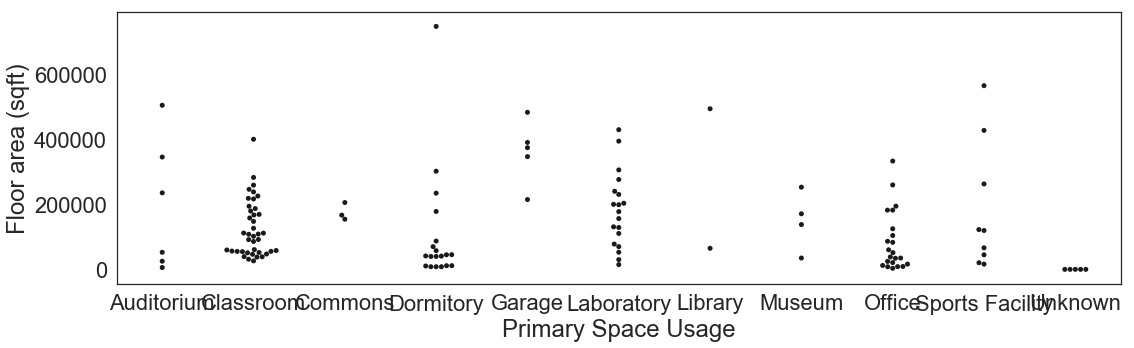

In [5]:
UT_meta_temp = UT_meta.sort_values(by='primaryspaceusage')
sns.set(
    context='notebook',
    style='white',
    palette='deep',
    font='sans-serif',
    font_scale=2,
    color_codes=True,
    rc=None)
plt.figure(figsize=[18,5])
sns.swarmplot(x='primaryspaceusage', y='sqft', data=UT_meta_temp, color='k')
#plt.ylim(-0.5,5.5)
plt.xlabel('Primary Space Usage')
plt.ylabel('Floor area (sqft)')

In [6]:
UT_e.head()

,Timestamp,EW28SS,T6VYSE,JAK2AE,WD96UE,SUWVYE,AGRIGB,RN5NH1,0IO3G9,13PZMR,...,52GWOQ,NVQOI4,AY4CSR,Z66H9B,0TDE3H,NQOENW,RB23PE,GN57GX,RYL6CQ,5XQXSQ
0,1/1/17 0:00,376,105,25,6,20,227,110.0400,816,16,...,66,51,36,21,0,75,28,100,39,696
1,1/1/17 1:00,376,104,23,6,21,225,108.0400,764,17,...,67,52,38,20,17999,73,28,99,38,688
2,1/1/17 2:00,369,105,24,6,21,227,108.5196,756,16,...,66,48,37,21,0,75,27,98,39,689
3,1/1/17 3:00,372,107,24,6,21,226,106.5195,744,16,...,66,50,39,21,0,74,26,99,39,696
4,1/1/17 4:00,379,108,24,6,20,228,108.0400,736,17,...,67,49,37,21,0,74,28,99,39,689


In [7]:
UT_e.Timestamp = pd.to_datetime(UT_e.Timestamp)

# 1.2 Converting from load profile to matrix profile

In [8]:
names = UT_e.columns.drop(['Timestamp'])
mp_adj = pd.DataFrame(columns=names)
mp_ind = pd.DataFrame(columns=names)
m=24

#For every building in column names
glb_start_time = time.time()

for i in names:
    #Calculate MP and MP index
    bldg = UT_e[str(i)]
    pattern = bldg.values
    mp = matrixProfile.stomp(pattern,m)
    #Append np.nan to Matrix profile to enable plotting against raw data
    madj = np.append(mp[0], np.zeros(m-1) + np.nan)
    mind = np.append(mp[1], np.zeros(m-1) + np.nan)
    #Save mp information
    mp_adj[str(i)] = madj
    mp_ind[str(i)] = mind

# will take around 7 minutes
print("--- total: %s seconds ---" % (time.time() - glb_start_time))

/anaconda3/lib/python3.7/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/anaconda3/lib/python3.7/site-packages/matrixprofile/utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/anaconda3/lib/python3.7/site-packages/matrixprofile/utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
/anaconda3/lib/python3.7/site-packages/matrixprofile/utils.py:200: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))


--- total: 474.7064628601074 seconds ---


# 2.1 Pick daily MP at midnight value

In [9]:
UT_e = UT_e.set_index('Timestamp')
UT_mp = mp_adj.set_index(UT_e.index)
UT_mpind = mp_ind.set_index(UT_e.index)

In [10]:
UT_e_0 = UT_e[UT_e.index.hour==0]
UT_mp_0 = UT_mp[UT_mp.index.hour==0]
UT_mpind_0 = UT_mpind[UT_mpind.index.hour==0]

In [11]:
UT_e_0.head()

,EW28SS,T6VYSE,JAK2AE,WD96UE,SUWVYE,AGRIGB,RN5NH1,0IO3G9,13PZMR,9EY76I,...,52GWOQ,NVQOI4,AY4CSR,Z66H9B,0TDE3H,NQOENW,RB23PE,GN57GX,RYL6CQ,5XQXSQ
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,376,105,25,6,20,227,110.040,816,16,356,...,66,51,36,21,0,75,28,100,39,696
2017-01-02,378,106,24,6,21,229,120.519,768,33,372,...,82,53,56,20,0,77,28,100,39,706
2017-01-03,412,106,23,6,21,219,113.040,764,21,369,...,62,60,37,21,1341,78,30,101,43,701
2017-01-04,435,103,25,6,22,217,0.000,968,19,382,...,69,107,42,23,1353,81,27,101,44,688
2017-01-05,474,102,26,6,23,211,113.519,1056,22,395,...,62,51,48,19,1377,75,27,102,44,697


# 2.2 Data reconstruction with other information

In [12]:
UT_result = pd.DataFrame(columns=['raw','mp','mp_ind'])

UT_result['raw'] = UT_e_0.values.reshape(46720)
UT_result['mp'] = UT_mp_0.values.reshape(46720)
UT_result['mp_ind'] = UT_mpind_0.values.reshape(46720)

UT_result.head()

,raw,mp,mp_ind
0,376.0,2.265768,8386.0
1,105.0,2.532754,641.0
2,25.0,3.782936,7371.0
3,6.0,3.405686,1666.0
4,20.0,4.561888,3383.0


In [13]:
df_names=[]
df_dates=[]
days=[]

for i in range(365):
    df_names = np.append(df_names, np.array(names))
    days = np.append(days, np.ones(len(names))*i)
for i in range(len(days)):
    df_dates = df_dates + [dt.datetime(year=2017,month=1,day=1) + dt.timedelta(days=days[i])]
    
UT_result['bldg'] = df_names
UT_result['date'] = df_dates

UT_result.head()

,raw,mp,mp_ind,bldg,date
0,376.0,2.265768,8386.0,EW28SS,2017-01-01
1,105.0,2.532754,641.0,T6VYSE,2017-01-01
2,25.0,3.782936,7371.0,JAK2AE,2017-01-01
3,6.0,3.405686,1666.0,WD96UE,2017-01-01
4,20.0,4.561888,3383.0,SUWVYE,2017-01-01


In [14]:
df_month=[]
df_daytype=[]
df_day=[]

for i in range(len(UT_result)):
    df_month = np.append(df_month, UT_result.date[i].strftime('%b'))
    df_daytype = np.append(df_daytype, UT_result.date[i].strftime('%a'))
    df_day = np.append(df_day, UT_result.date[i].strftime('%d'))
    
UT_result['month'] = df_month
UT_result['daytype'] = df_daytype
UT_result['day'] = df_day

UT_result.head()

,raw,mp,mp_ind,bldg,date,month,daytype,day
0,376.0,2.265768,8386.0,EW28SS,2017-01-01,Jan,Sun,01
1,105.0,2.532754,641.0,T6VYSE,2017-01-01,Jan,Sun,01
2,25.0,3.782936,7371.0,JAK2AE,2017-01-01,Jan,Sun,01
3,6.0,3.405686,1666.0,WD96UE,2017-01-01,Jan,Sun,01
4,20.0,4.561888,3383.0,SUWVYE,2017-01-01,Jan,Sun,01


In [15]:
# Just for generating metadata efficiently
UT_meta_temp = pd.DataFrame(columns=['bldg','sqft','psu'])
UT_meta_temp.bldg = np.array(names)

for i in range(len(UT_meta_temp)):
    for j in range(len(UT_meta)):
        if UT_meta_temp.bldg[i] == UT_meta.anon_id[j]:
            UT_meta_temp.sqft[i] = UT_meta.sqft[j]
            UT_meta_temp.psu[i] = UT_meta.primaryspaceusage[j]
UT_meta_temp.head()

,bldg,sqft,psu
0,EW28SS,181805,Office
1,T6VYSE,177708,Dormitory
2,JAK2AE,55240,Classroom
3,WD96UE,8004,Office
4,SUWVYE,41241,Dormitory


In [16]:
psus = UT_meta_temp.psu
sqfts = UT_meta_temp.sqft
df_psus=[]
df_sqfts=[]

for i in range(365):
    df_psus = np.append(df_psus, np.array(psus))
    df_sqfts = np.append(df_sqfts, np.array(sqfts))
    
UT_result['psu'] = df_psus
UT_result['sqft'] = df_sqfts

UT_result.head()

,raw,mp,mp_ind,bldg,date,month,daytype,day,psu,sqft
0,376.0,2.265768,8386.0,EW28SS,2017-01-01,Jan,Sun,01,Office,181805
1,105.0,2.532754,641.0,T6VYSE,2017-01-01,Jan,Sun,01,Dormitory,177708
2,25.0,3.782936,7371.0,JAK2AE,2017-01-01,Jan,Sun,01,Classroom,55240
3,6.0,3.405686,1666.0,WD96UE,2017-01-01,Jan,Sun,01,Office,8004
4,20.0,4.561888,3383.0,SUWVYE,2017-01-01,Jan,Sun,01,Dormitory,41241


# 2.3 MP distributions by date and meta information

Text(0, 0.5, 'Matrix profile')

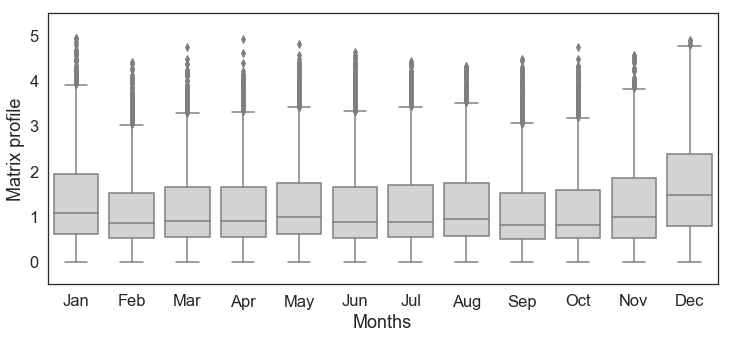

In [17]:
sns.set(
    context='notebook',
    style='white',
    palette='deep',
    font='sans-serif',
    font_scale=1.5,
    color_codes=True,
    rc=None)
plt.figure(figsize=[12,5])
sns.boxplot(x='month', y='mp', data=UT_result, color='lightgray')
plt.ylim(-0.5,5.5)
plt.xlabel('Months')
plt.ylabel('Matrix profile')

Text(0, 0.5, 'Matrix profile')

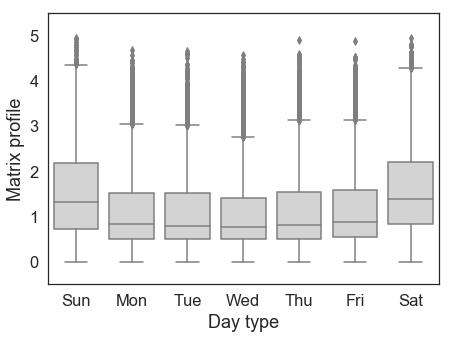

In [18]:
sns.set(
    context='notebook',
    style='white',
    palette='deep',
    font='sans-serif',
    font_scale=1.5,
    color_codes=True,
    rc=None)
plt.figure(figsize=[7,5])
sns.boxplot(x='daytype', y='mp', data=UT_result, color='lightgray')
plt.ylim(-0.5,5.5)
plt.xlabel('Day type')
plt.ylabel('Matrix profile')

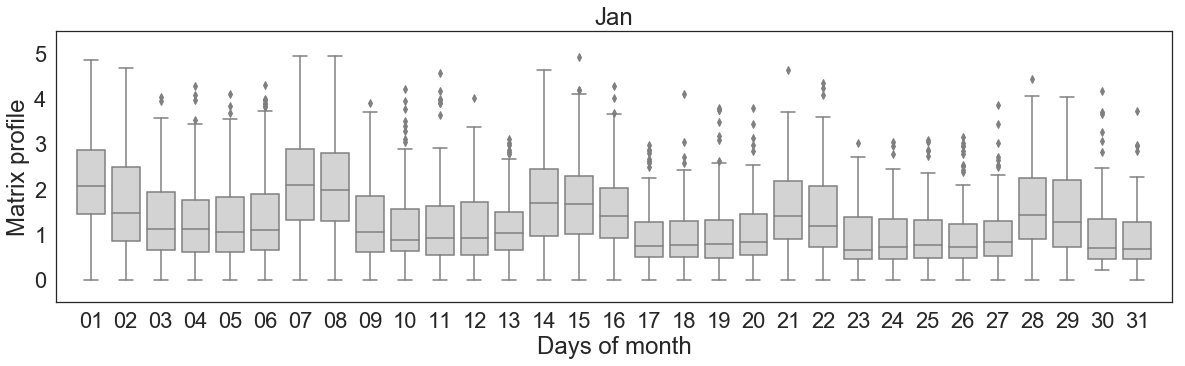

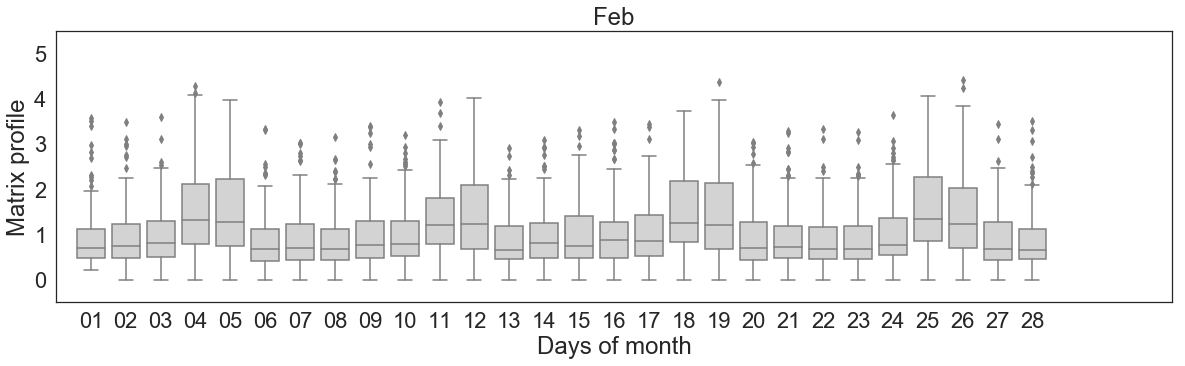

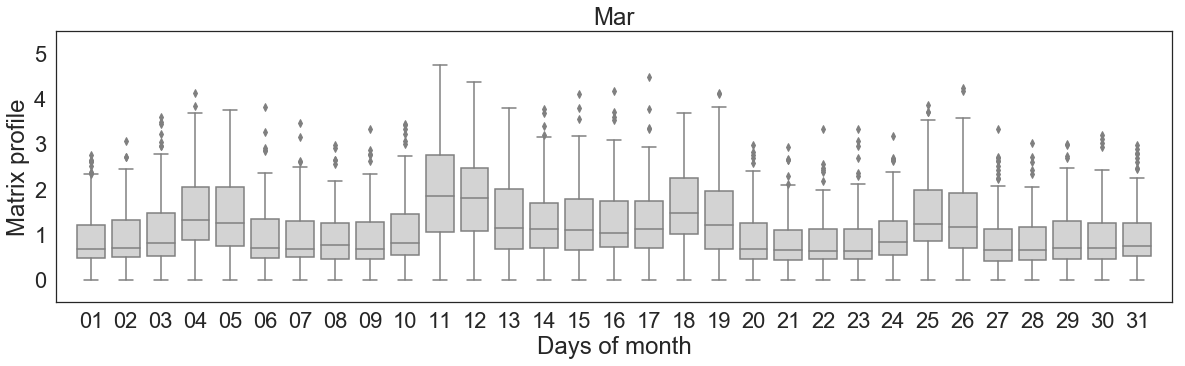

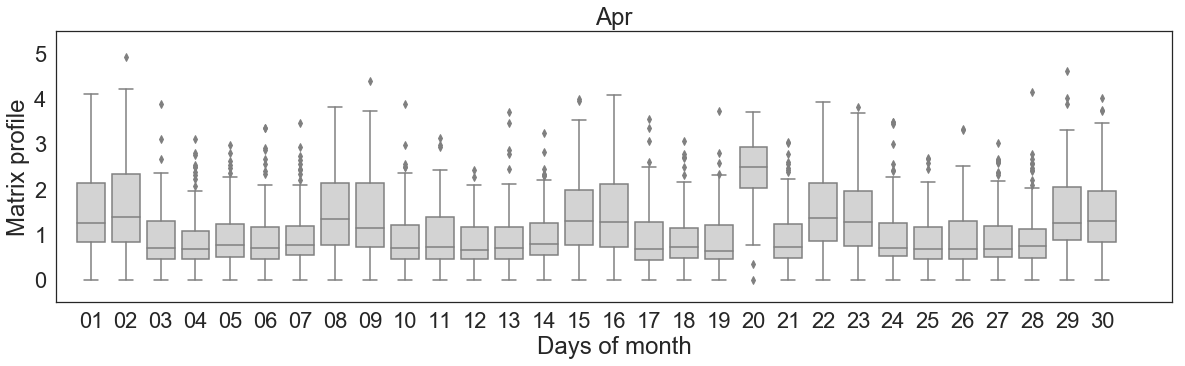

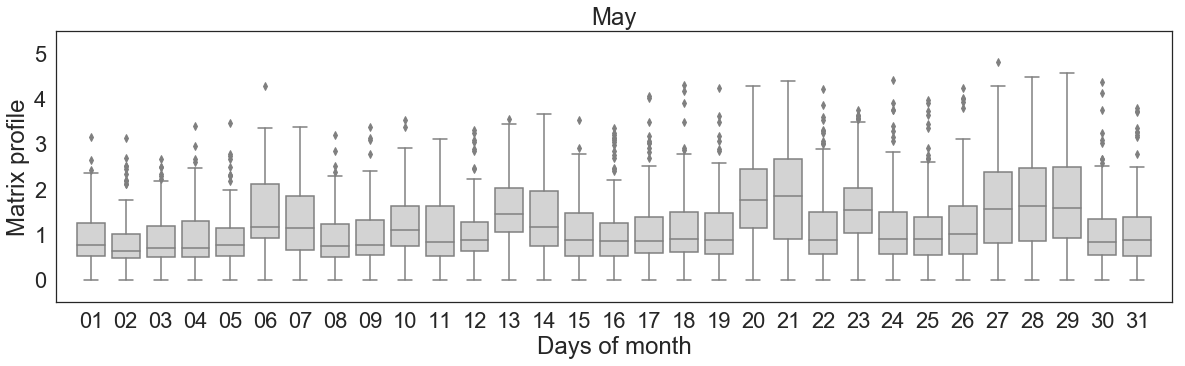

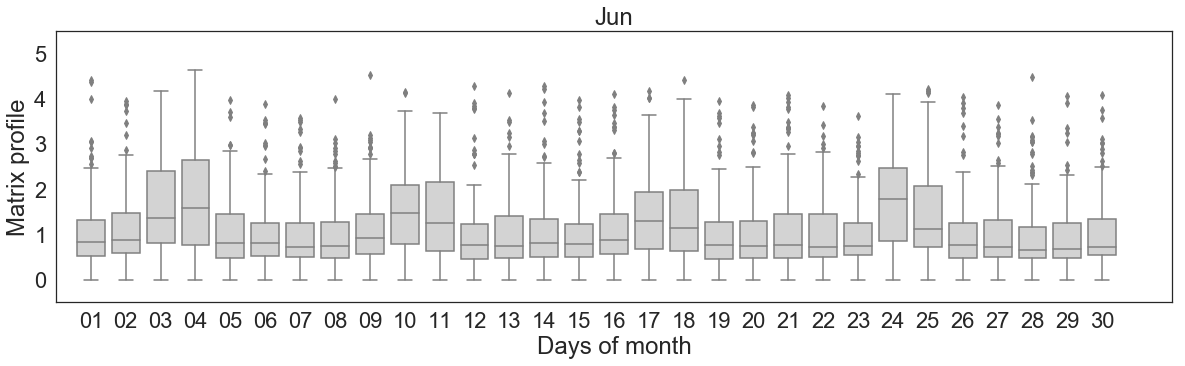

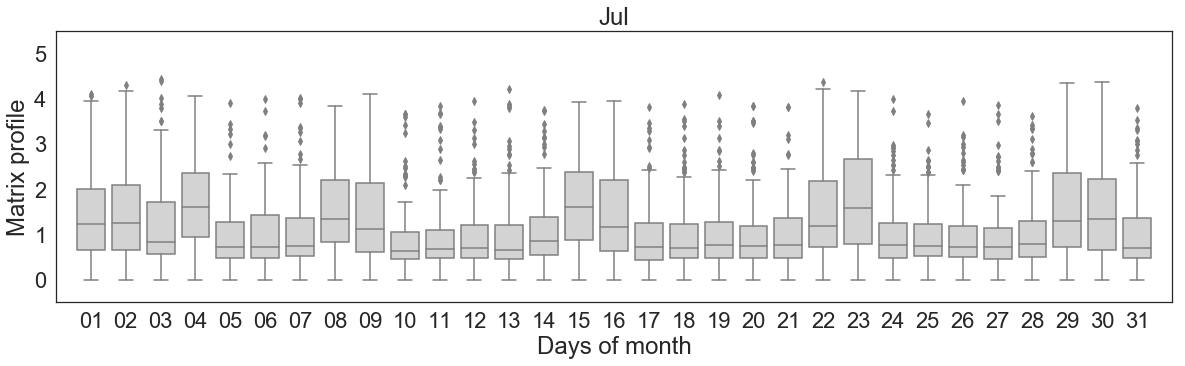

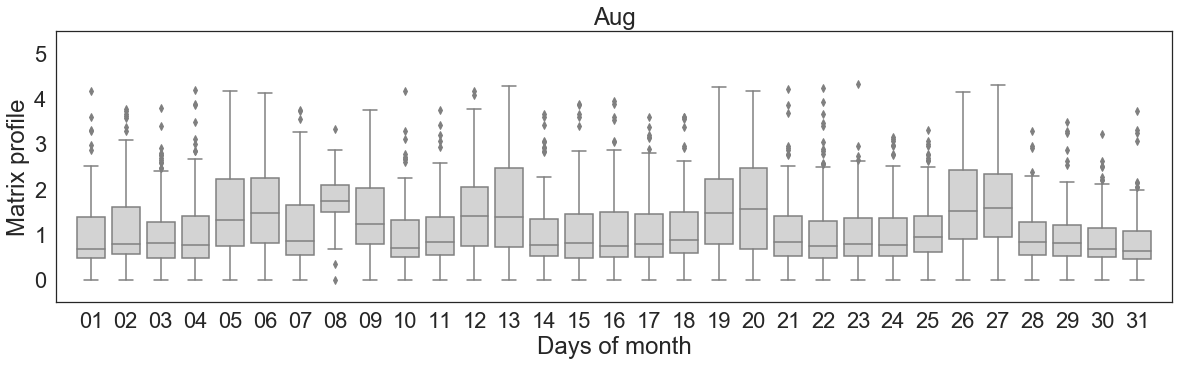

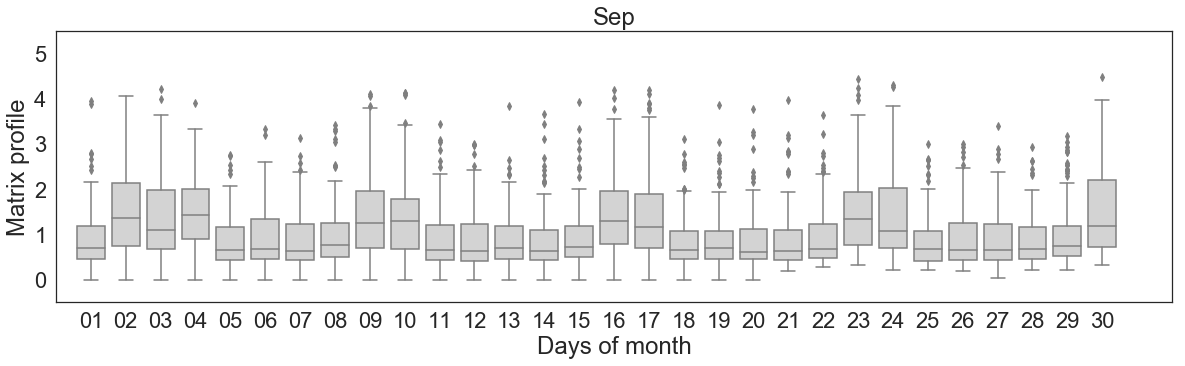

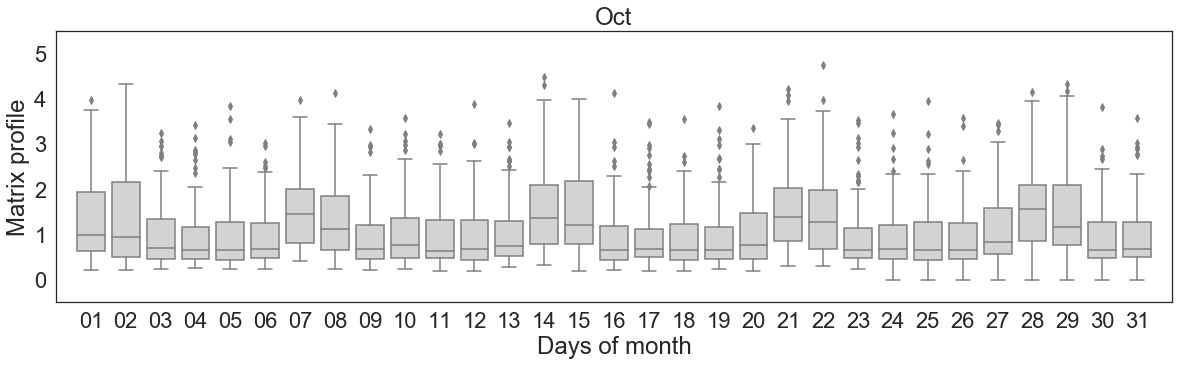

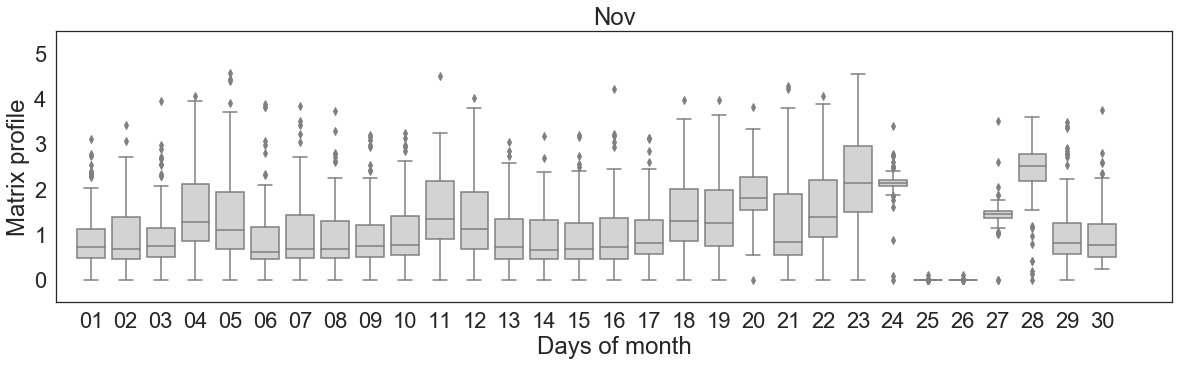

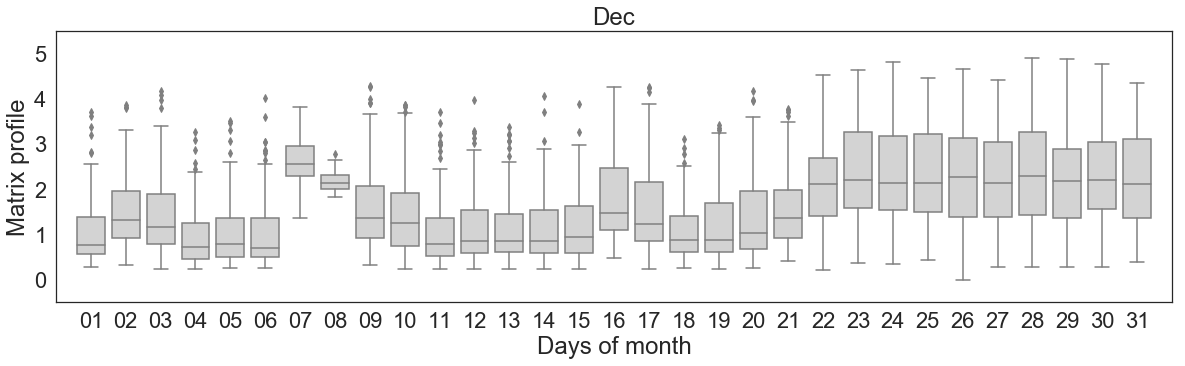

In [19]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in months:
    events = UT_result[UT_result.month == i]
    sns.set(
    context='notebook',
    style='white',
    palette='deep',
    font='sans-serif',
    font_scale=2,
    color_codes=True,
    rc=None)
    plt.figure(figsize=[20,5])
    sns.boxplot(x='day', y='mp', data=events, color='lightgray')
    plt.title(i)
    plt.ylim(-0.5,5.5)
    plt.xlim(-1,31)
    plt.xlabel('Days of month')
    plt.ylabel('Matrix profile')
    #plt.savefig("Graph" + str(i) +".png", bbox_inches='tight', format="PNG")
    plt.show()

Text(0, 0.5, 'Matrix profile')

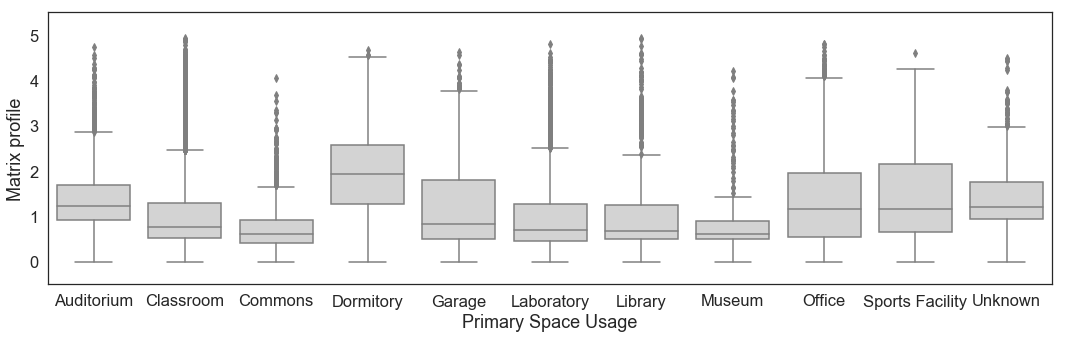

In [20]:
UT_result_temp = UT_result.sort_values(by='psu')
sns.set(
    context='notebook',
    style='white',
    palette='deep',
    font='sans-serif',
    font_scale=1.5,
    color_codes=True,
    rc=None)
plt.figure(figsize=[18,5])
sns.boxplot(x='psu', y='mp', data=UT_result_temp, color='lightgray')
plt.ylim(-0.5,5.5)
plt.xlabel('Primary Space Usage')
plt.ylabel('Matrix profile')

Text(0, 0.5, 'Matrix profile')

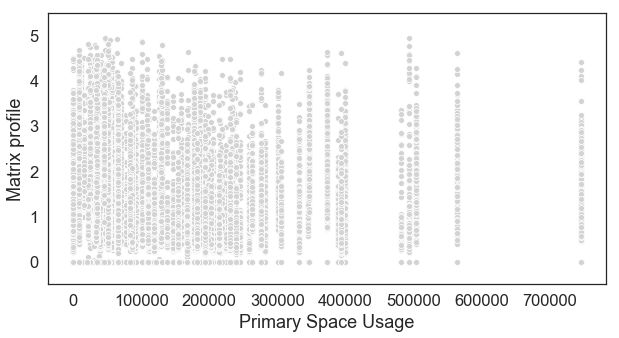

In [21]:
sns.set(
    context='notebook',
    style='white',
    palette='deep',
    font='sans-serif',
    font_scale=1.5,
    color_codes=True,
    rc=None)
plt.figure(figsize=[10,5])
sns.scatterplot(x='sqft', y='mp', data=UT_result_temp, color='lightgray')
plt.ylim(-0.5,5.5)
plt.xlabel('Primary Space Usage')
plt.ylabel('Matrix profile')

# 3.1 MP disttributions for daily and typical daytype)

Text(0, 0.5, 'Matrix profile')

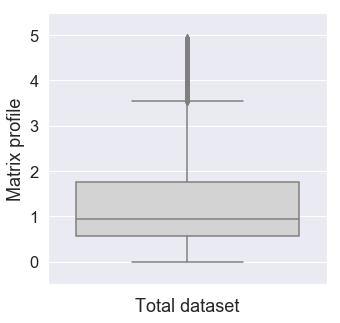

In [22]:
#visualize the total distribution
sns.set(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1.5,
    color_codes=True,
    rc=None)
plt.figure(figsize=[5,5])
sns.boxplot(UT_result.mp, color='lightgray', orient='vertical')
plt.ylim(-0.5,5.5)
plt.xlabel('Total dataset')
plt.ylabel('Matrix profile')

In [23]:
#build daytype distributions
mon_result = UT_result.mp[UT_result.daytype == 'Mon']
tue_result = UT_result.mp[UT_result.daytype == 'Tue']
wed_result = UT_result.mp[UT_result.daytype == 'Wed']
thr_result = UT_result.mp[UT_result.daytype == 'Thu']
fri_result = UT_result.mp[UT_result.daytype == 'Fri']
sat_result = UT_result.mp[UT_result.daytype == 'Sat']
sun_result = UT_result.mp[UT_result.daytype == 'Sun']

# 3.2 KS test

In [24]:
#test k-s test for each daily distribution
ks_test = pd.DataFrame(columns=['D','p'], index=pd.date_range(pd.datetime(year=2017,month=1,day=1), periods=365))

for i in pd.date_range(pd.datetime(year=2017,month=1,day=1), periods=365):
    events = UT_result.mp[UT_result.date == i]
    if i.weekday() == 0:
        test = stats.ks_2samp(events, mon_result)
        ks_test.D[i] = test.statistic
        ks_test.p[i] = test.pvalue
        
    if i.weekday() == 1:
        test = stats.ks_2samp(events, tue_result)
        ks_test.D[i] = test.statistic
        ks_test.p[i] = test.pvalue
        
    if i.weekday() == 2:
        test = stats.ks_2samp(events, wed_result)
        ks_test.D[i] = test.statistic
        ks_test.p[i] = test.pvalue
        
    if i.weekday() == 3:
        test = stats.ks_2samp(events, thr_result)
        ks_test.D[i] = test.statistic
        ks_test.p[i] = test.pvalue
        
    if i.weekday() == 4:
        test = stats.ks_2samp(events, fri_result)
        ks_test.D[i] = test.statistic
        ks_test.p[i] = test.pvalue
        
    if i.weekday() == 5:
        test = stats.ks_2samp(events, sat_result)
        ks_test.D[i] = test.statistic
        ks_test.p[i] = test.pvalue
        
    if i.weekday() == 6:
        test = stats.ks_2samp(events, sun_result)
        ks_test.D[i] = test.statistic
        ks_test.p[i] = test.pvalue
        
ks_test.head()

,D,p
2017-01-01,0.26135,4.72087e-08
2017-01-02,0.235577,1.27737e-06
2017-01-03,0.170072,0.00118134
2017-01-04,0.165415,0.00176517
2017-01-05,0.115084,0.066471


## 3.2.1 Visualize ks test result

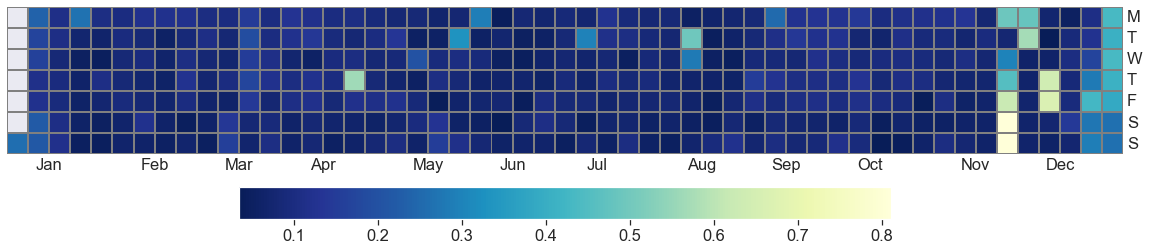

In [25]:
#visualize k-s test (for distance)
events = ks_test
events = pd.Series(ks_test.D)

fig = plt.figure(figsize=[20,4])
ax = fig.add_subplot(111)
cax = calmap.yearplot(events, cmap="YlGnBu_r", ax=ax, daylabels='MTWTFSS', linewidth=1, linecolor='grey', fillcolor='grey')
#cax = calmap.yearplot(events, cmap="Greys_r", ax=ax, daylabels='MTWTFSS', fillcolor='grey')
fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal')

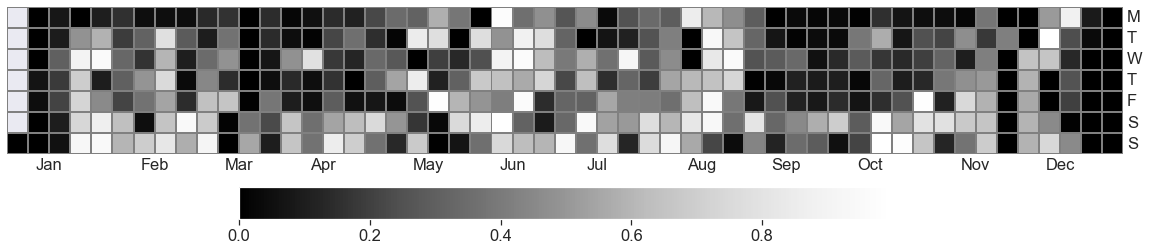

In [26]:
#visualize k-s test (for distance)
events = ks_test
events = pd.Series(ks_test.p)

fig = plt.figure(figsize=[20,4])
ax = fig.add_subplot(111)
cax = calmap.yearplot(events, cmap="Greys_r", ax=ax, daylabels='MTWTFSS', linewidth=1, linecolor='grey', fillcolor='grey')
#cax = calmap.yearplot(events, cmap="Greys_r", ax=ax, daylabels='MTWTFSS', fillcolor='grey')
fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal')

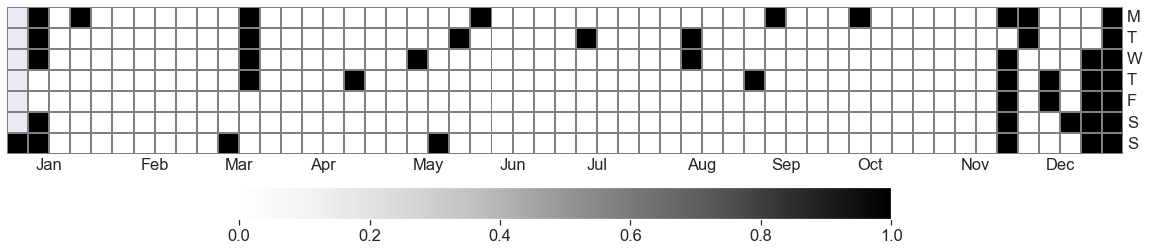

In [27]:
ks_test['det'] = np.where(ks_test['p']<0.01, 1, 0)
#ks_test['det'] = np.where((ks_test['p']<0.05) & (ks_test['D']>0.4), 1, 0)
events = ks_test    
events = pd.Series(ks_test.det)

fig = plt.figure(figsize=[20,4])
ax = fig.add_subplot(111)
cax = calmap.yearplot(events, cmap="Greys", ax=ax, daylabels='MTWTFSS', linewidth=1, linecolor='grey',fillcolor='grey')
fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal')

## 3.1.2 Nr of rejected days by different p-values

In [28]:
p_nr = pd.DataFrame(columns=['p','nr'])
p_nr.p = [0.01,0.05,0.1,0.15,0.2]
p_nr.nr = np.zeros(len(p_nr.p))
for i in range(len(p_nr)):
    ks_test['det'] = np.where(ks_test['p']<p_nr.p[i], 1, 0)
    temp = ks_test    
    temp = pd.Series(ks_test.det)
    p_nr.nr[i] = np.sum(temp)
p_nr

,p,nr
0,0.01,46.0
1,0.05,75.0
2,0.10,102.0
3,0.15,133.0
4,0.20,151.0


# 4.1 investigation on rejected days

In [29]:
UT_e_z = pd.DataFrame(stats.zscore(UT_e, axis = 0),index=UT_e.index)

In [30]:
ks_test['det'] = np.where(ks_test['p']<0.01, 1, 0)
discord = ks_test[ks_test.det==1]
discord.head()
len(discord)

46

(0, 1)

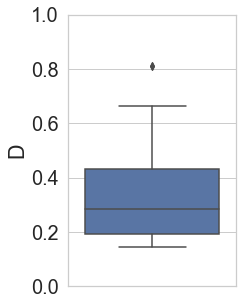

In [31]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.8)
plt.figure(figsize=[3,5])
sns.boxplot(discord['D'].astype(float), orient='v')
plt.ylim(0,1)

In [32]:
discord_sort = discord.sort_values(by='D')
discord_sort.head()

,D,p,det
2017-10-02,0.144081,0.00963419,1
2017-12-16,0.145883,0.0084229,1
2017-03-13,0.147236,0.00760712,1
2017-08-31,0.150541,0.00590686,1
2017-03-15,0.153245,0.00478249,1


2017-12-08 00:00:00 0.6631610576923077 1.6253833733477672e-49


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


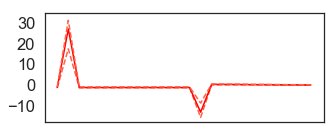

2017-11-26 00:00:00 0.8110259433962265 7.134833317180543e-74


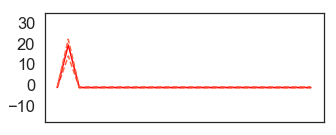

2017-11-25 00:00:00 0.8114483173076923 6.349134907113492e-74


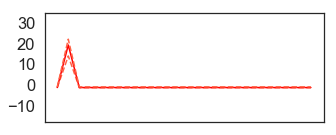

In [33]:
for i in discord_sort.index[-3:]:
    discord_temp = UT_e_z[i:i+dt.timedelta(hours=23)]
    print(i,ks_test.D[i],ks_test.p[i])
    
    discord_q = pd.DataFrame(columns=['q1','q2','q3'],index=discord_temp.index)
    for j in range(len(discord_temp)):
        discord_q['q1'][j] = np.percentile(discord_temp.iloc[j,:], 25)
        discord_q['q2'][j] = np.percentile(discord_temp.iloc[j,:], 50)
        discord_q['q3'][j] = np.percentile(discord_temp.iloc[j,:], 75)
    
    sns.set(style='white', font_scale=1.5)
    plt.figure(figsize=(5,2))
    plt.plot(discord_q.q1, '--', color='tomato')
    plt.plot(discord_q.q2, color='red')
    plt.plot(discord_q.q3, '--', color='tomato')
    
    plt.yticks([-10,0,10,20,30])
    plt.xticks([])
    plt.ylim(-18,35)
    #plt.xlim(i,i + dt.timedelta(hours=23))
    plt.savefig("Graph" + str(i) +".png", bbox_inches='tight', format="PNG")
    
    plt.show()

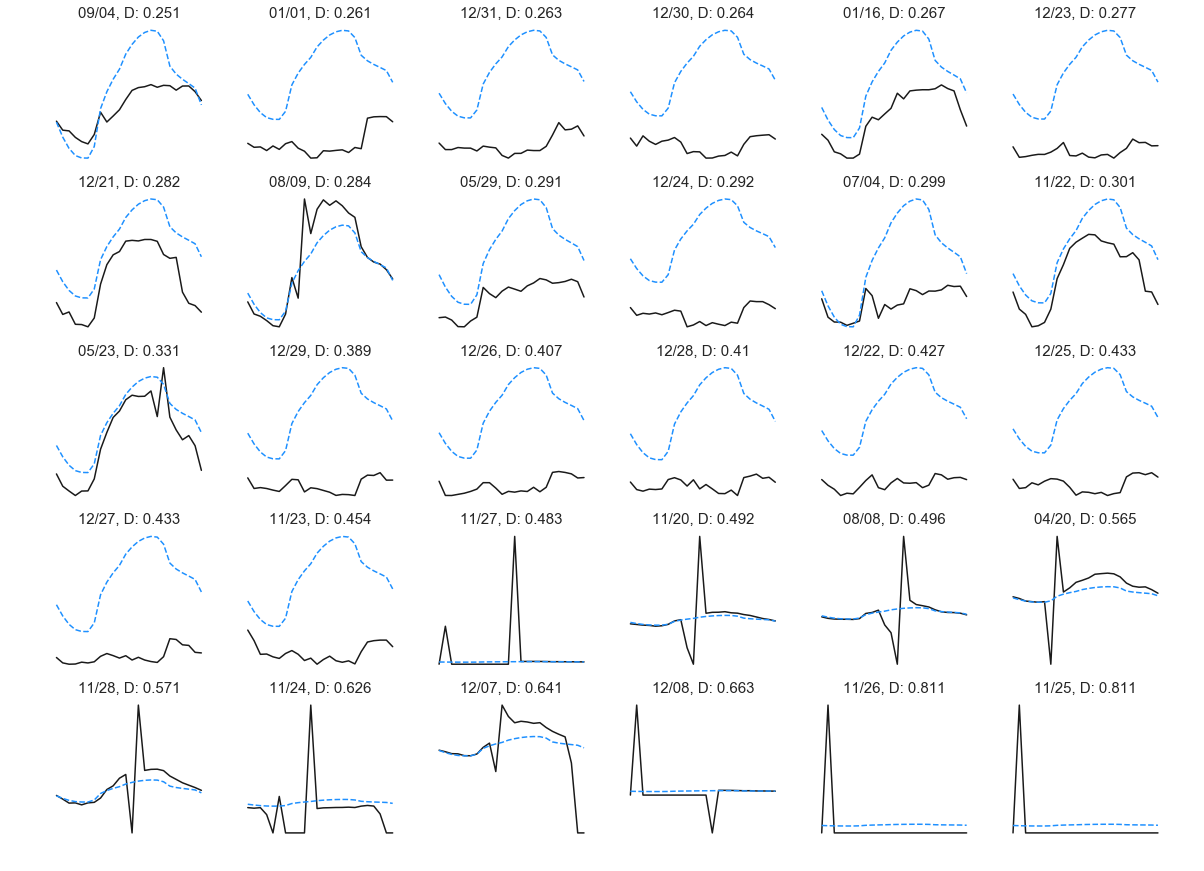

In [705]:
fig, axs = plt.subplots(5,6, figsize=(20,15),frameon=False)
fs=15

for j,i in zip(discord_sort.index[-30:], range(30)):
    
    discord_temp = UT_e_z[j:j+dt.timedelta(hours=23)]
    discord_q = pd.DataFrame(columns=['q1','q2','q3','n'],index=discord_temp.index)

    for k in range(len(discord_temp)):
        discord_q['q2'][k] = np.percentile(discord_temp.iloc[k,:], 50)
        discord_q['n'][k] = X_q.q2[k]

    if i < 6:
        date = list(str(j).split(' '))
        date = list(list(str(j).split(' '))[0].split('-'))
        axs[0,i].plot(discord_q.q2, color='k')
        axs[0,i].plot(discord_q.n, '--', color='dodgerblue')
        axs[0,i].axis('off')
        axs[0,i].set_title(date[1]+'/'+date[2]+', '+
                           'D: '+str(round(ks_test.D[j],3)), fontsize=fs)
    elif i < 12:
        date = list(str(j).split(' '))
        date = list(list(str(j).split(' '))[0].split('-'))
        axs[1,i%6].plot(discord_q.q2, color='k')
        axs[1,i%6].plot(discord_q.n, '--', color='dodgerblue')
        axs[1,i%6].axis('off')
        axs[1,i%6].set_title(date[1]+'/'+date[2]+', '+
                           'D: '+str(round(ks_test.D[j],3)), fontsize=fs)
    elif i < 18:
        date = list(str(j).split(' '))
        date = list(list(str(j).split(' '))[0].split('-'))
        axs[2,i%6].plot(discord_q.q2, color='k')
        axs[2,i%6].plot(discord_q.n, '--', color='dodgerblue')
        axs[2,i%6].axis('off')
        axs[2,i%6].set_title(date[1]+'/'+date[2]+', '+
                           'D: '+str(round(ks_test.D[j],3)), fontsize=fs)
    elif i < 24:
        date = list(str(j).split(' '))
        date = list(list(str(j).split(' '))[0].split('-'))
        axs[3,i%6].plot(discord_q.q2, color='k')
        axs[3,i%6].plot(discord_q.n, '--', color='dodgerblue')
        axs[3,i%6].axis('off')
        axs[3,i%6].set_title(date[1]+'/'+date[2]+', '+
                           'D: '+str(round(ks_test.D[j],3)), fontsize=fs)
    else:
        date = list(str(j).split(' '))
        date = list(list(str(j).split(' '))[0].split('-'))
        axs[4,i%6].plot(discord_q.q2, color='k')
        axs[4,i%6].plot(discord_q.n, '--', color='dodgerblue')
        axs[4,i%6].axis('off')
        axs[4,i%6].set_title(date[1]+'/'+date[2]+', '+
                           'D: '+str(round(ks_test.D[j],3)), fontsize=fs)

# 4.2 investigation on non-rejected days

In [535]:
motif = ks_test[ks_test.det==0]
motif.head()
len(motif)

319

(0, 1)

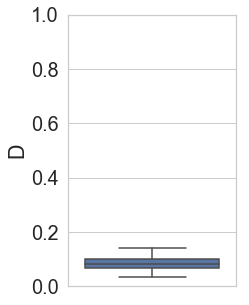

In [536]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.8)
plt.figure(figsize=[3,5])
sns.boxplot(motif['D'].astype(float), orient='v')
plt.ylim(0,1)

2017-01-05 00:00:00 0.11508413461538464 0.06647102521930796


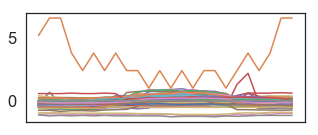

In [537]:
for i in motif[:1].index:
    sns.set(style='white', font_scale=1.5)
    print(i,ks_test.D[i],ks_test.p[i])
    plt.figure(figsize=(5,2))
    plt.plot(UT_e_z[i:i+dt.timedelta(hours=23)])
    #plt.yticks([])
    plt.xticks([])
    #plt.xlim(i,i + dt.timedelta(hours=23))
    #plt.savefig("Graph" + str(i) +".png", bbox_inches='tight', format="PNG")
    plt.show()

2017-12-09 00:00:00 0.07542067307692307 0.4577699733264652


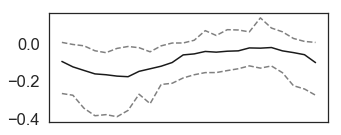

2017-12-10 00:00:00 0.05999410377358491 0.7438449761628687


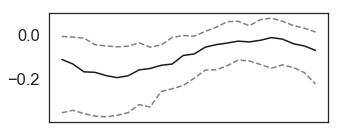

2017-12-11 00:00:00 0.05198317307692307 0.8781307214175441


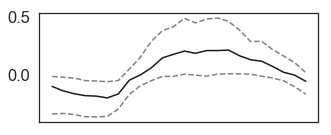

2017-12-12 00:00:00 0.09089543269230771 0.23881140725924013


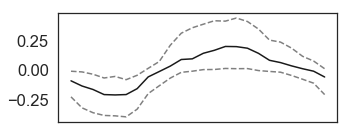

2017-12-13 00:00:00 0.10246394230769229 0.13457922883704743


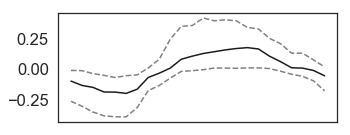

2017-12-14 00:00:00 0.08939302884615385 0.2559276192938549


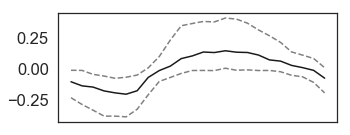

2017-12-15 00:00:00 0.09465144230769232 0.19978930385594773


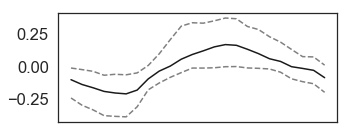

2017-12-17 00:00:00 0.07532429245283018 0.45919085434927664


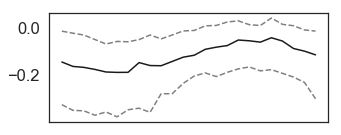

2017-12-18 00:00:00 0.11042668269230768 0.08706654212662089


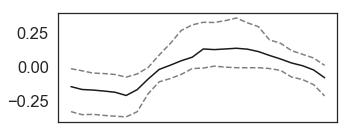

2017-12-19 00:00:00 0.12394831730769229 0.038559756004904015


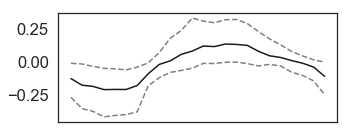

In [538]:
for i in motif.index[-10:]:
    motif_temp = UT_e_z[i:i+dt.timedelta(hours=23)]
    print(i,ks_test.D[i],ks_test.p[i])
    
    motif_q = pd.DataFrame(columns=['q1','q2','q3'],index=motif_temp.index)
    for j in range(len(discord_temp)):
        motif_q['q1'][j] = np.percentile(motif_temp.iloc[j,:], 25)
        motif_q['q2'][j] = np.percentile(motif_temp.iloc[j,:], 50)
        motif_q['q3'][j] = np.percentile(motif_temp.iloc[j,:], 75)
    
    sns.set(style='white', font_scale=1.5)
    plt.figure(figsize=(5,2))
    plt.plot(motif_q.q1, '--', color='grey')
    plt.plot(motif_q.q2, color='k')
    plt.plot(motif_q.q3, '--', color='grey')
    
    #plt.yticks([])
    plt.xticks([])
    #plt.xlim(i,i + dt.timedelta(hours=23))
    #plt.savefig("Graph" + str(i) +".png", bbox_inches='tight', format="PNG")
    
    plt.show()

In [539]:
motif_ts = pd.DataFrame({})

for i in motif.index:
    #motif_temp = UT_e[i:i+dt.timedelta(hours=23)]
    motif_temp = UT_e_z[i:i+dt.timedelta(hours=23)]
    motif_temp = np.array(motif_temp.T.values)
    motif_temp = pd.DataFrame(motif_temp, dtype=float)
    motif_ts = pd.concat([motif_ts, motif_temp], axis=0, sort=False)

In [541]:
names = UT_meta_temp.bldg
psus = UT_meta_temp.psu
sqfts = UT_meta_temp.sqft
dates = motif.index
df_names=[]
df_psus=[]
df_sqfts=[]
df_dates=[]
temp=pd.DataFrame({'date':np.ones(len(names))})

for i in range(len(motif)):
    df_names = np.append(df_names, np.array(names))
    df_psus = np.append(df_psus, np.array(psus))
    df_sqfts = np.append(df_sqfts, np.array(sqfts))
    temp['date'] = dates[i]
    df_dates = np.append(df_dates, np.array(temp.date, dtype=str))
    
motif_ts['bldg'] = df_names
motif_ts['psu'] = df_psus
motif_ts['sqft'] = df_sqfts
motif_ts['date'] = df_dates
motif_ts.date = pd.to_datetime(motif_ts.date)

motif_ts.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,bldg,psu,sqft,date
0,0.025738,-0.035899,-0.047640,-0.071121,-0.053510,-0.041769,-0.053510,0.187169,0.292833,0.278158,...,0.266417,0.298704,0.143143,0.072700,0.063895,NaN,EW28SS,Office,181805,2017-01-05
1,-0.245886,-0.245886,-0.255444,-0.236327,-0.245886,-0.255444,-0.236327,-0.236327,-0.140739,-0.245886,...,-0.226768,-0.226768,-0.236327,-0.207650,-0.217209,NaN,T6VYSE,Dormitory,177708,2017-01-05
2,-0.292960,-0.371637,-0.332299,-0.371637,-0.371637,-0.371637,-0.253622,-0.371637,-0.253622,-0.056929,...,-0.135606,-0.174944,-0.056929,-0.135606,-0.135606,NaN,JAK2AE,Classroom,55240,2017-01-05
3,-0.092933,-0.092933,-0.092933,-0.092933,-0.092933,-0.092933,-0.092933,-0.092933,0.098573,0.098573,...,-0.092933,-0.092933,-0.092933,-0.092933,0.098573,NaN,WD96UE,Office,8004,2017-01-05
4,-0.427652,-0.463237,-0.498822,-0.463237,-0.463237,-0.498822,-0.463237,-0.392067,-0.427652,-0.427652,...,-0.427652,-0.427652,-0.392067,-0.392067,-0.392067,NaN,SUWVYE,Dormitory,41241,2017-01-05


In [661]:
X = motif_ts.iloc[:, 0:24]
X.head()
len(X)

40832

In [662]:
X=X.dropna()
len(X)

40832

In [663]:
X = X.reset_index()

In [664]:
X = X.drop(columns=['index'])

In [665]:
X_q = pd.DataFrame(columns=['q1','q2','q3'],index=np.arange(24))

for i in range(24):
    X_q['q1'][i] = np.percentile(X.iloc[:,i], 25)
    X_q['q2'][i] = np.percentile(X.iloc[:,i], 50)
    X_q['q3'][i] = np.percentile(X.iloc[:,i], 75)

40832


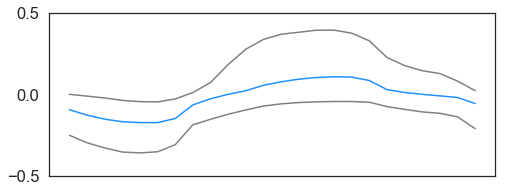

In [681]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(8,3))
plt.plot(X_q.q1, color='grey')
plt.plot(X_q.q2, color='dodgerblue')
plt.plot(X_q.q3, color='grey')
plt.xticks([])
plt.ylim(-0.45,0.45)
plt.yticks([-0.5,0,0.5])
print(len(X))

# 4.2.1 Clustering analysis on non-rejected profiles

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, silhouette_score

In [290]:
Y = pd.DataFrame(columns=['C'],index=X.index)
sse = {}
CH = {}
SS = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    Y['C'] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    CH[k] = calinski_harabaz_score(X, kmeans.labels_)
    SS[k] = silhouette_score(X, kmeans.labels_)
    print(k)

2
3
4
5
6
7
8
9


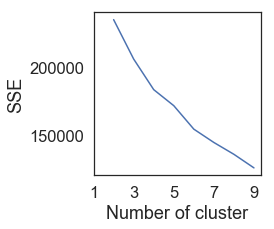

In [291]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(3,3))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.xticks([1,3,5,7,9])
plt.show()

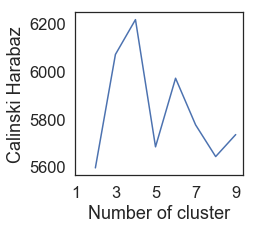

In [292]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(3,3))
plt.plot(list(CH.keys()), list(CH.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Calinski Harabaz")
plt.xticks([1,3,5,7,9])
plt.show()

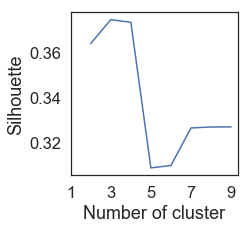

In [293]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(3,3))
plt.plot(list(SS.keys()), list(SS.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette")
plt.xticks([1,3,5,7,9])
plt.show()

In [319]:
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(X)
Y["C"] = kmeans.labels_

In [374]:
A=X[Y['C']==0]
B=X[Y['C']==1]
C=X[Y['C']==2]

In [375]:
A_q = pd.DataFrame(columns=['q1','q2','q3'],index=np.arange(24))
B_q = pd.DataFrame(columns=['q1','q2','q3'],index=np.arange(24))
C_q = pd.DataFrame(columns=['q1','q2','q3'],index=np.arange(24))

for i in range(24):
    A_q['q1'][i] = np.percentile(A.iloc[:,i], 25)
    A_q['q2'][i] = np.percentile(A.iloc[:,i], 50)
    A_q['q3'][i] = np.percentile(A.iloc[:,i], 75)
    
    B_q['q1'][i] = np.percentile(B.iloc[:,i], 25)
    B_q['q2'][i] = np.percentile(B.iloc[:,i], 50)
    B_q['q3'][i] = np.percentile(B.iloc[:,i], 75)
    
    C_q['q1'][i] = np.percentile(C.iloc[:,i], 25)
    C_q['q2'][i] = np.percentile(C.iloc[:,i], 50)
    C_q['q3'][i] = np.percentile(C.iloc[:,i], 75)

28088


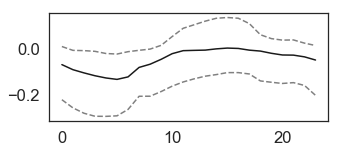

In [397]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(5,2))
plt.plot(A_q.q1, '--', color='grey')
plt.plot(A_q.q2, color='k')
plt.plot(A_q.q3, '--', color='grey')
#plt.ylim(-2,2)
print(len(A))

3


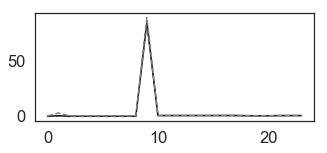

In [398]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(5,2))
plt.plot(B_q.q1, '--', color='grey')
plt.plot(B_q.q2, color='k')
plt.plot(B_q.q3, '--', color='grey')
#plt.ylim(-2,30)
print(len(B))

12654


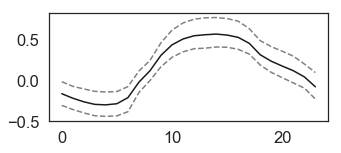

In [399]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(5,2))
plt.plot(C_q.q1, '--', color='grey')
plt.plot(C_q.q2, color='k')
plt.plot(C_q.q3, '--', color='grey')
#plt.ylim(-2,25)
print(len(C))